---
**Chapter 09**
# **Advanced deep learning for computer vision**
---


In [4]:
# System Libraries
import importlib, sys, os
import numpy as np
import random

# TensorFlow Libraries
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
from tensorflow import keras
import tensorflow as tf

# User Libraries
sys.path.append("../")
from modules import common, chapter_01, chapter_09

# Reload Libraries
importlib.reload(chapter_01)
importlib.reload(chapter_09)
importlib.reload(common)

# Check GPU
print(tf.config.list_physical_devices())

# Module variables
img_size = (200, 200)
batch_size = 64
epochs = 10

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


---
- Three essential computer vision tasks
  - Image classification
  - Image segmentation (1. Semantic 2. Instance)
  - Object detection
- Modern convnet architecture patterns
  - Modularity, hierarchy, reuse
  - Residual connections
  - Batch normalizaton
  - Depthwise separable convolution
  - Mini Xception model
- Interpret what convnets learn
  - Visualize intermediate activations
  - Visualize convet filters
  - Visualize heatmaps of class acitvation
---

- Image classification
  - Assign one or more classes to an image
  - Binary classification
  - Mutliclass single-label classification
  - Mutliclass multi-label classification
  - **Logit layer is Dense**
- Image segmentation
  - Semantic segmentation
    - Each pixel is independently classified into a segmentation cateogory
    - **Logit layer is Conv2D**
    - Example:
      - If there are two cats in an image, pixels of both will be mapped as **cat**
  - Instance segmentation
    - Each pixel is independently classified into a segmentation category
    - Parse out object instances
    - Example:
      - If there are two cats in an image, pixels will be mapped as **cat1** and **cat2**
  - Segmentation mask:
    - Single channel (0-255) label of an image where each integer represents a unique class
    - Example:
      - 1: Background, 2: Bottle 
- Object detection
  - RetinaNet: https://keras.io/examples/vision/retinanet

---
# **Semantic segmentation**
---

### <ins />**Dataset**

In [45]:
input_raw, input_imgs, labels, num_labels = chapter_09.dataset(img_size)

### <ins />**Exploration**

Number of labels:  400


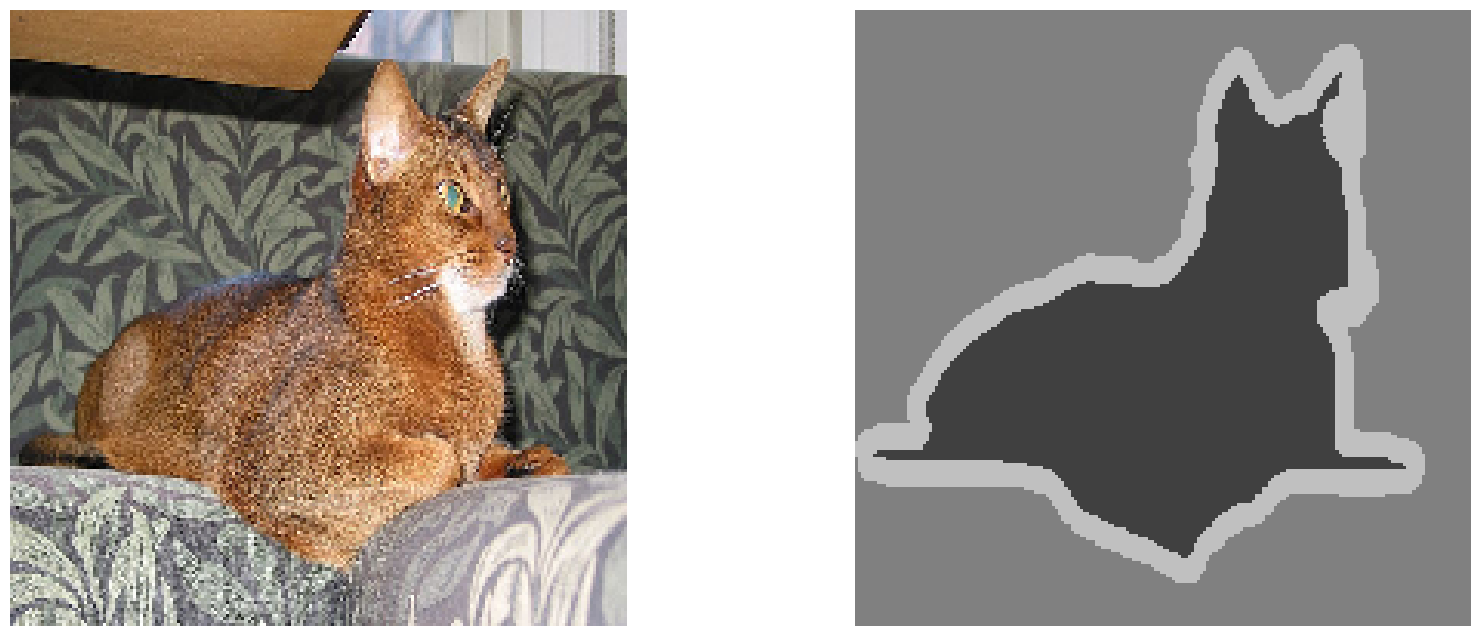

In [50]:
print("Number of labels: ", num_labels)
explore_idx = random.randint(0, num_labels - 1)
chapter_09.explore(input_raw[explore_idx], labels[explore_idx])

### <ins />**Downsample and upsample**

**Downsample:**
- Encode images into smaller feature maps
- Conv2D

**Upsample:**
- To have shape of segmentation mask same as input image
- Conv2DTranspose

**Note:**
- For segmentation and detection, use stride instead of maxpooling

### <ins />**Model**

In [9]:
def get_model(input_size, num_classes):
    # -----------------------------------------
    # Input Layer
    # -----------------------------------------
    i = keras.Input(shape=input_size + (3,), name="Layer_Input")
    x = keras.layers.Rescaling(1.0 / 255, name="Layer_Rescale")(i)
    # -----------------------------------------
    # Downsampling Layers
    # -----------------------------------------
    x = keras.layers.SeparableConv2D(filters=64, kernel_size=3, padding="same", activation=tf.nn.relu, strides=2, name="Conv_1")(x)
    x = keras.layers.SeparableConv2D(filters=64, kernel_size=3, padding="same", activation=tf.nn.relu, name="Conv_2")(x)
    x = keras.layers.BatchNormalization()(x)
    r = x
    x = keras.layers.SeparableConv2D(filters=128, kernel_size=3, padding="same", activation=tf.nn.relu, strides=2, name="Conv_3")(x)
    r = keras.layers.SeparableConv2D(filters=128, kernel_size=1, strides=2)(r)
    x = keras.layers.add([x, r])
    x = keras.layers.SeparableConv2D(filters=128, kernel_size=3, padding="same", activation=tf.nn.relu, name="Conv_4")(x)
    x = keras.layers.SeparableConv2D(filters=256, kernel_size=3, padding="same", activation=tf.nn.relu, strides=2, name="Conv_5")(x)
    x = keras.layers.SeparableConv2D(filters=256, kernel_size=3, padding="same", activation=tf.nn.relu, name="Conv_6")(x)
    # -----------------------------------------
    # Upsampling Layers
    # -----------------------------------------
    x = keras.layers.Conv2DTranspose(filters=256, kernel_size=3, padding="same", activation=tf.nn.relu, name="Conv_6T")(x)
    x = keras.layers.Conv2DTranspose(filters=256, kernel_size=3, padding="same", activation=tf.nn.relu, strides=2, name="Conv_5T")(x)
    x = keras.layers.Conv2DTranspose(filters=128, kernel_size=3, padding="same", activation=tf.nn.relu, name="Conv_4T")(x)
    x = keras.layers.Conv2DTranspose(filters=128, kernel_size=3, padding="same", activation=tf.nn.relu, strides=2, name="Conv_3T")(x)
    x = keras.layers.Conv2DTranspose(filters=64, kernel_size=3, padding="same", activation=tf.nn.relu, name="Conv_2T")(x)
    x = keras.layers.Conv2DTranspose(filters=64, kernel_size=3, padding="same", activation=tf.nn.relu, strides=2, name="Conv_1T",
                                     kernel_regularizer=keras.regularizers.l2(l2=0.002))(x)
    x = keras.layers.Dropout(rate=0.25)(x)
    # -----------------------------------------
    # Output Layer
    # -----------------------------------------
    o = keras.layers.Conv2D(filters=num_classes, kernel_size=3, padding="same", activation=tf.nn.softmax, name="Layer_Output")(x)
    # -----------------------------------------
    # Model
    # -----------------------------------------
    model = keras.Model(inputs=i, outputs=o)
    return model

### <ins />**Train**

In [11]:
model = get_model(input_size=img_size, num_classes=3)
chapter_01.compile(model=model, metrics=None)
history = chapter_01.train(input_imgs, labels, model, 0.3, 64, callbacks=common.callbacks(), epochs=epochs)

### <ins />**Graph**

In [ ]:
common.plot_simple(
    data=[history.history["loss"], history.history["val_loss"]],
    labels=["01_segmentation_loss", "01_segmentation_val_loss"],
    start_index=3,
)

### <ins />**Test**

In [ ]:
test_idx = random.randint(0, num_labels)
test_img = input_raw[test_idx]
mask = model.predict(np.expand_dims(test_img, 0))[0]
chapter_09.explore_test(test_img, mask)

---
# **Architecture patterns**
---

### <ins />**Definitions**

- **Architecture**
  - Types of layer
  - Number of layer
  - Configuration of layer
  - Arrangment of layer
- **Good architecture**
  - Efficient use of available data 
  - Makes problem simpler for gradient descent
- **Architecture patterns**
  - Residual connection
  - Batch normalization
  - Depthwise separable convolution
- **Modularity, hierarachy, reuse (MHR)**
  - Convnet architectures are structured in pyramid-like repeated group of layers
  - Conv2D
  - Maxpooling
  - Dense
  - Softmax

---
# **Residual connection**
---

##### **Definitions**

- **Vanishing gradients**
    - When there are many layers, the noise starts overwhelming gradient information
    - Backpropagation stops working

- **Residual connection (information shortcut)**
    - It allows gradient informations to propagate noiselessly from top to bottom layers
    - It allows to build models with many layers without vanishing gradient problem
    - It was proposed by ResNet architecture
    - Add input of a layer back to its output

- **Best practices**
    - When output dim != input dim, use a buffer conv layer
    - Buffer conv layer
      - With maxpooling, kernel_size=1 and strides=pool_size
      - Without maxpooling, kernel_size=1 and strides=1

- **Ablation**
    - Convnet architectures are result of continuously trying and keeping what works
    - In the end, remove layer by layer until the network is bare minimum


##### **Case-1: When there is no maxpooling**

In [ ]:
# --------------------------------------
# Without residual connection
# --------------------------------------
inputs = keras.Input(shape=(32, 32, 3))
x = keras.layers.Conv2D(filters=32, kernel_size=3)(inputs)
outputs = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
model1 = keras.Model(inputs=inputs, outputs=outputs, name="no_residual")
# --------------------------------------
# With residual connection
# --------------------------------------
inputs = keras.Input(shape=(32, 32, 3))
x = keras.layers.Conv2D(filters=32, kernel_size=3)(inputs)
residual = x
outputs = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
residual = keras.layers.Conv2D(filters=64, kernel_size=1, strides=1)(residual)  # Buffer layer
outputs = keras.layers.add([outputs, residual])
model2 = keras.Model(inputs=inputs, outputs=outputs, name="with_residual")

In [ ]:
model1.summary()

In [ ]:
model2.summary()

##### **Case-2: When there is maxpooling**

In [ ]:
# --------------------------------------
# Without residual connection
# --------------------------------------
inputs = keras.Input(shape=(32, 32, 3))
x = keras.layers.Conv2D(filters=32, kernel_size=3)(inputs)
x = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
outputs = keras.layers.MaxPool2D(pool_size=2, padding="same")(x)
model1 = keras.Model(inputs=inputs, outputs=outputs, name="maxpool_no_residual")
# --------------------------------------
# With residual connection
# --------------------------------------
inputs = keras.Input(shape=(32, 32, 3))
x = keras.layers.Conv2D(filters=32, kernel_size=3)(inputs)
residual = x
x = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
outputs = keras.layers.MaxPool2D(pool_size=2, padding="same")(x)
residual = keras.layers.Conv2D(filters=64, kernel_size=1, strides=2)(residual)  # Buffer layer
outputs = keras.layers.add([outputs, residual])
model2 = keras.Model(inputs=inputs, outputs=outputs, name="maxpool_with_residual")

In [ ]:
model1.summary()

In [ ]:
model2.summary()

##### **End-to-end example**
  - TODO

---
# **Batch normalization**
--- 

### <ins />**Definitions**

- **Normalization**
  - Data should be centered around 0 by subtracting the mean from data
  - Data should have unit variance by dividing the data with its std dev

- **Batch normalization**
  - Adaptively normalizing the data as mean and variance change over time during training
  - Even if the data entering the layer is normalized, the output may not be normalized
  - Thats why batch normalization is used

- **Why batch normalization works?**
  - There are several optimization techniques in machine learning without formal reasoning explanation
  - They work empirically in real world (how is known, why is unknown)
  - Example: Batch normalization

- **Best practices**
  - For large models, residual connection and batch normalization should be used
  - When finetuning, layers with batch normalization **should be frozen**
  - Use activation after normalization (improves utilization of relu)

##### **Case-1: When there is no activation**

In [ ]:
# --------------------------------------
# Without batch normalization
# --------------------------------------
inputs = keras.Input(shape=(32, 32, 3))
x = keras.layers.Conv2D(filters=32, kernel_size=3)(inputs)
outputs = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
model1 = keras.Model(inputs=inputs, outputs=outputs, name="no_batch_norm")
# --------------------------------------
# With batch normalization
# --------------------------------------
inputs = keras.Input(shape=(32, 32, 3))
x = keras.layers.Conv2D(filters=32, kernel_size=3, use_bias=False)(inputs)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
model2 = keras.Model(inputs=inputs, outputs=outputs, name="with_batch_norm")

In [ ]:
model1.summary()

In [ ]:
model2.summary()

##### **Case-2: When there is activation**

In [ ]:
# --------------------------------------
# Without batch normalization
# --------------------------------------
inputs = keras.Input(shape=(32, 32, 3))
x = keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu)(inputs)
outputs = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
model1 = keras.Model(inputs=inputs, outputs=outputs, name="activation_no_batch_norm")
# --------------------------------------
# With batch normalization
# --------------------------------------
inputs = keras.Input(shape=(32, 32, 3))
x = keras.layers.Conv2D(filters=32, kernel_size=3, use_bias=False)(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(activation=tf.nn.relu)(x)
outputs = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
model2 = keras.Model(inputs=inputs, outputs=outputs, name="activation_with_batch_norm")

In [ ]:
model1.summary()

In [ ]:
model2.summary()

---
# **Depthwise separable convolution**
---

### <ins />**Definitions**

TODO

### <ins />**Example**

##### **With standard convolution**

In [ ]:
i = keras.Input(shape=(200, 200, 3))
o = keras.layers.Conv2D(filters=3, kernel_size=3, padding="same", activation=tf.nn.softmax)(i)
model1 = keras.Model(inputs=i, outputs=o)

##### **With separable convolution**

In [ ]:
i = keras.Input(shape=(200, 200, 3))
o = keras.layers.SeparableConv2D(filters=3, kernel_size=3, padding="same", activation=tf.nn.softmax)(i)
model2 = keras.Model(inputs=i, outputs=o)

### <ins />**Comparison**

In [ ]:
model1.summary()

In [ ]:
model2.summary()

---
# **Debugging convolution models**
---

Aka Deconvolution or Model Layer Interpretation

### <ins />**1- Visualize activations of convolution layers**

- Get outputs of consecutive convolution layers and plot any/all channels of each layer
  - Top layers detect edges (similar to Canny Edge Detector or Hough Transform)
  - Bottom layes detect class specific abstract information
  - Anology: Magnifying glass Far (general features) and Near (specific features)

Specific filters learned by convolution layer is not deterministed (different results for each of N trials)

### <ins />**2- Visualize filters of convolution layers**

- Using Gradient Ascent
- Starting from blank image, apply gradient descent on input image so as to maximize the convolution filter response
- Selected image is the one where filter is maximally responsive

To note:
- Use model.predict for production
- Use model for debugging i.e. when gradients of model is needed

### <ins />**3- Visualize heatmaps of class activation**

- Useful for classification tasks
- CAM: Class acitvation maps
- Grad-CAM: Which part of the image led the model to decide a class
  - Get activations of last convolution layer before logit (called last acitvations)
  - Map last activations to logit layer's predicted classes
  - Compute gradient of top predicted class with respect to last activations
  - Apply importance weighting to gradients tensor

---